In [1]:
## Build a basic chatbot with Langgraph

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    ## messages have the type list. the add messages function in the annotation defines how this state key should be updated
    ## in this case it append message to the list instead of overwriting it
    messages:Annotated[list,add_messages]


In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
os.environ['GROQ_API_KEY']=os.environ['GROQ_API_KEY']
os.environ['TAVILY_API_KEY']=os.environ['TAVILY_API_KEY']

In [20]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model='openai/gpt-oss-20b')
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7f256fe4ac10>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7f256fe4b610>, model_name='openai/gpt-oss-20b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [21]:
def chatbot(state:State):
    return {'messages':[llm.invoke(state['messages'])]}

graph_builder=StateGraph(State)
graph_builder.add_node('llmchatbot',chatbot)

graph_builder.add_edge(START,'llmchatbot')
graph_builder.add_edge('llmchatbot',END)

graph_builder=graph_builder.compile()


In [22]:
response=graph_builder.invoke({'messages':'hi'})
response['messages'][-1].content

'Hello! How can I help you today?'

In [23]:
for event in graph_builder.stream({'messages':'Hi How are you?'}):
    for value in event.values():
        print(value['messages'][-1].content)

Hello! I'm doing great, thanks for asking. How about you—how’s your day going?


In [ ]:
## chatbot with tools
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke('what is langgraph?')

{'query': 'what is langgraph?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.ibm.com/think/topics/langgraph',
   'title': 'What is LangGraph?',
   'content': 'LangGraph isan open source AI agent frameworkfor building, deploying, and managing complex generative AI workflows, using graph-based architectures.',
   'score': 0.94956195,
   'raw_content': None},
  {'url': 'https://www.geeksforgeeks.org/machine-learning/what-is-langgraph/',
   'title': 'What is LangGraph?',
   'content': 'LangGraph is an open-source framework built by LangChain that streamlines the creation and management of AI agent workflows. By treating workflows as interconnected nodes and edges, LangGraph offers a scalable, transparent and developer-friendly way to design advanced AI systems ranging from simple chatbots to multi-agent system. * ****Enhanced decision-making:**** Models relationships between nodes, enabling AI agents to learn from past actions and feedback

In [29]:
## custom functon
from langchain_core.tools import tool 

@tool
def multiply(a: int, b: int) -> int:
    """Multiplies two numbers, a and b."""
    return a * b

# Instantiate the pre-built tool
web_search_tool = TavilySearch(max_results=2)

# The tools list contains the actual instantiated/decorated tool objects
tools = [web_search_tool, multiply]

# Bind the model (This line is now correct)
llm_with_tools = llm.bind_tools(tools)

In [30]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_calling_llm(state:State):
    return{'messages':llm_with_tools.invoke(state['messages'])}


builder=StateGraph(State)
builder.add_node('tool_calling_llm',tool_calling_llm)
builder.add_node('tools',ToolNode(tools))

builder.add_edge(START,'tool_calling_llm')
builder.add_conditional_edges('tool_calling_llm',tools_condition,{'tools':'tools',END:END})
builder.add_edge('tools',END)

graph=builder.compile()

In [32]:
response=graph.invoke({'messages':'What is the recent ai news'})
response['messages'][-1].content

'{"query": "latest AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.finextra.com/blogposting/29509/data-led-innovation-with-ai-transforming-financial-services", "title": "Data-Led Innovation with AI: Transforming Financial Services: By Erica Andersen - Finextra Research", "score": 0.61140573, "published_date": "Sun, 05 Oct 2025 08:52:37 GMT", "content": "Following 2\\n\\nOpinions 65\\n\\nFollowUnfollow)\\n\\n### The AI Tsunami: Is Assistive Intelligence the Way to Navigate the Waves of Innovation in Finance?\\n\\n28 September\\n\\n### Data Sovereignty and AI: Building a Secure and Compliant Future for Financial Institutions\\n\\n21 September\\n\\n### Reshaping and Optimizing Finance with AI: A New Era of Cost Savings and Efficiency\\n\\n14 September\\n\\n### Demystifying the Data Deluge: Unlocking Actionable Insights in Financial Markets\\n\\n07 September [...] Increased Efficiency:Banks have reduced operational costs by automating m

In [33]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_b7f1746f-1177-4cb7-ac92-a93b55e821a9)
 Call ID: fc_b7f1746f-1177-4cb7-ac92-a93b55e821a9
  Args:
    query: latest AI news
    search_depth: advanced
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "latest AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.finextra.com/blogposting/29509/data-led-innovation-with-ai-transforming-financial-services", "title": "Data-Led Innovation with AI: Transforming Financial Services: By Erica Andersen - Finextra Research", "score": 0.61140573, "published_date": "Sun, 05 Oct 2025 08:52:37 GMT", "content": "Following 2\n\nOpinions 65\n\nFollowUnfollow)\n\n### The AI Tsunami: Is Assistive 

In [34]:
response=graph.invoke({'messages':'What is 2 multiplied 23'})
response['messages'][-1].content

'46'

In [37]:
response=graph.invoke({'messages':'What is 2 multiplied by 23 and then multiply 10'})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 multiplied by 23 and then multiply 10
================================== Ai Message ==================================

2 × 23 = 46, and 46 × 10 = **460**.


In [39]:
response=graph.invoke({'messages':'Give me the recent ai news and then multiply 2  by 10'})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 2  by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_fb76d5d9-49e5-4372-a09b-342db66981ad)
 Call ID: fc_fb76d5d9-49e5-4372-a09b-342db66981ad
  Args:
    query: recent AI news
    search_depth: advanced
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.artificialintelligence-news.com/news/the-rise-of-algorithmic-agriculture-ai-steps-in/", "title": "The rise of algorithmic agriculture? AI steps in - AI News", "score": 0.7746691, "published_date": "Tue, 30 Sep 2025 16:53:15 GMT", "content": "### The value gap from AI investments is widening dangerously fast\n\nSeptember 30, 2025\n\n### Inside Huawei’s Shanghai a

In [40]:
## ReAct agent architecture
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_calling_llm(state:State):
    return{'messages':llm_with_tools.invoke(state['messages'])}


builder=StateGraph(State)
builder.add_node('tool_calling_llm',tool_calling_llm)
builder.add_node('tools',ToolNode(tools))

builder.add_edge(START,'tool_calling_llm')
builder.add_conditional_edges('tool_calling_llm',tools_condition)
builder.add_edge('tools','tool_calling_llm')
builder.add_edge('tool_calling_llm',END)

graph=builder.compile()

In [41]:
response=graph.invoke({'messages':'Give me the recent ai news and then multiply 2  by 10'})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 2  by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_47771860-c4a5-4103-a73e-a90b7da0238d)
 Call ID: fc_47771860-c4a5-4103-a73e-a90b7da0238d
  Args:
    query: recent AI news
    search_depth: advanced
    time_range: week
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://hai.stanford.edu/ai-index/2025-ai-index-report", "title": "The 2025 AI Index Report | Stanford HAI", "content": "In 2024, U.S. federal agencies introduced 59 AI-related regulations—more than double the number in 2023—and issued by twice as many agencies. Globally, legislative mentions of AI rose 21.3% across 75 countries since 2023, marking a

In [42]:
## Adding memory in agentic graph

response=graph.invoke({'messages':'Hello my name is nancy'})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello my name is nancy
================================== Ai Message ==================================

Hello Nancy! 👋 How can I help you today?


In [43]:
response=graph.invoke({'messages':'What is my name?'})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

I’m sorry, but I don’t have any information about your name. If you tell me, I’ll remember it for the rest of this conversation.


In [50]:
## ReAct agent architecture
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()

def tool_calling_llm(state:State):
    return{'messages':llm_with_tools.invoke(state['messages'])}


builder=StateGraph(State)
builder.add_node('tool_calling_llm',tool_calling_llm)
builder.add_node('tools',ToolNode(tools))

builder.add_edge(START,'tool_calling_llm')
builder.add_conditional_edges('tool_calling_llm',tools_condition)
builder.add_edge('tools','tool_calling_llm')
builder.add_edge('tool_calling_llm',END)

graph=builder.compile(checkpointer=memory)

In [51]:
config={'configurable':{'thread_id':'1'}}

response=graph.invoke({'messages':'Hi my name is Nancy'},config=config)

response

{'messages': [HumanMessage(content='Hi my name is Nancy', additional_kwargs={}, response_metadata={}, id='ec52001f-268e-48be-a3b4-8cdbfa9bf0e9'),
  AIMessage(content='Hello Nancy! How can I help you today?', additional_kwargs={'reasoning_content': 'User says: "Hi my name is Nancy". Probably respond politely. No request. Just greeting.'}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 1389, 'total_tokens': 1429, 'completion_time': 0.040403234, 'prompt_time': 0.013105484, 'queue_time': 0.089222645, 'total_time': 0.053508718, 'prompt_tokens_details': {'cached_tokens': 1280}}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_80501ff3a1', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--fae8c5ad-433a-4c50-8aa0-3fc57077c886-0', usage_metadata={'input_tokens': 1389, 'output_tokens': 40, 'total_tokens': 1429})]}

In [52]:
response=graph.invoke({'messages':'What is my name?'},config=config)

response

{'messages': [HumanMessage(content='Hi my name is Nancy', additional_kwargs={}, response_metadata={}, id='ec52001f-268e-48be-a3b4-8cdbfa9bf0e9'),
  AIMessage(content='Hello Nancy! How can I help you today?', additional_kwargs={'reasoning_content': 'User says: "Hi my name is Nancy". Probably respond politely. No request. Just greeting.'}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 1389, 'total_tokens': 1429, 'completion_time': 0.040403234, 'prompt_time': 0.013105484, 'queue_time': 0.089222645, 'total_time': 0.053508718, 'prompt_tokens_details': {'cached_tokens': 1280}}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_80501ff3a1', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--fae8c5ad-433a-4c50-8aa0-3fc57077c886-0', usage_metadata={'input_tokens': 1389, 'output_tokens': 40, 'total_tokens': 1429}),
  HumanMessage(content='What is my name?', additional_kwargs={}, response_metadata={}, id='28971c1b-5264-464a

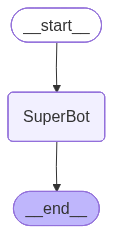

In [55]:
## Streaming
from IPython.display import Image,display

memory=MemorySaver()

def superbot(state:State):
    return {'messages':[llm.invoke(state['messages'])]}

builder=StateGraph(State)
builder.add_node('SuperBot',superbot)
builder.add_edge(START,'SuperBot')
builder.add_edge('SuperBot',END)

graph=builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [56]:
config={'configurable':{'thread_id':'1'}}

response=graph.invoke({'messages':'Hi my name is Nancy and i like singing'},config=config)

response

{'messages': [HumanMessage(content='Hi my name is Nancy and i like singing', additional_kwargs={}, response_metadata={}, id='d564595f-3a0e-4658-991e-e9a2c15004e0'),
  AIMessage(content='Hey Nancy! 🎤 It’s great to meet a fellow music lover. What kind of singing do you enjoy the most? Do you have a favorite genre or artist that inspires you? If you’re up for it, I’d love to hear more about your musical journey!', additional_kwargs={'reasoning_content': 'The user says "Hi my name is Nancy and i like singing". They didn\'t ask a question. We should respond with a friendly greeting, perhaps ask about their singing. The instructions: we must respond as ChatGPT. We should be friendly, maybe ask about what kind of singing, favorite songs, etc. There\'s no conflict. So we can respond accordingly.'}, response_metadata={'token_usage': {'completion_tokens': 137, 'prompt_tokens': 80, 'total_tokens': 217, 'completion_time': 0.136357679, 'prompt_time': 0.003897529, 'queue_time': 0.086996398, 'total_t

## Streaming

Methods: stream() and astream()

- These methods are sync and async methods for streaming back results

Additional parameters in streaming modes for graph state

- values: This streams the full state of the graph after each node is called

- updates: This stream updates to the state of the graph after each node is called.

In [57]:
config={'configurable':{'thread_id':'3'}}

for chunk in graph.stream({'messages':'Hi, my name is Nancy and I like singing'},config,stream_mode='updates'):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content='Hi Nancy! 🎤 It’s great to meet someone who loves singing. What kind of music do you enjoy the most? Do you have a favorite genre, artist, or song that you’re always humming? I’d love to hear more about your musical tastes!', additional_kwargs={'reasoning_content': 'We need to respond to Nancy, who says "Hi, my name is Nancy and I like singing". We should greet and respond. The user didn\'t ask a question. We can respond with friendly tone, ask about her singing, maybe ask what kind of songs she likes. The system says we can provide information, but also we can ask about preferences. So respond accordingly.'}, response_metadata={'token_usage': {'completion_tokens': 138, 'prompt_tokens': 81, 'total_tokens': 219, 'completion_time': 0.136757744, 'prompt_time': 0.004377143, 'queue_time': 0.085275097, 'total_time': 0.141134887}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_c5a89987dc', 'service_tier': 'on_demand', 'finish_reason'

In [58]:
config={'configurable':{'thread_id':'3'}}

for chunk in graph.stream({'messages':'Hi, my name is Nancy and I like singing'},config,stream_mode='values'):
    print(chunk)

{'messages': [HumanMessage(content='Hi, my name is Nancy and I like singing', additional_kwargs={}, response_metadata={}, id='5c324881-dca4-4d36-b65d-ebdad9805663'), AIMessage(content='Hi Nancy! 🎤 It’s great to meet someone who loves singing. What kind of music do you enjoy the most? Do you have a favorite genre, artist, or song that you’re always humming? I’d love to hear more about your musical tastes!', additional_kwargs={'reasoning_content': 'We need to respond to Nancy, who says "Hi, my name is Nancy and I like singing". We should greet and respond. The user didn\'t ask a question. We can respond with friendly tone, ask about her singing, maybe ask what kind of songs she likes. The system says we can provide information, but also we can ask about preferences. So respond accordingly.'}, response_metadata={'token_usage': {'completion_tokens': 138, 'prompt_tokens': 81, 'total_tokens': 219, 'completion_time': 0.136757744, 'prompt_time': 0.004377143, 'queue_time': 0.085275097, 'total_t

In [59]:
config={'configurable':{'thread_id':'4'}}

for chunk in graph.stream({'messages':'Hi, my name is Nancy and I like singing'},config,stream_mode='updates'):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content='Hi Nancy! 🎤 That’s awesome—what kind of music do you enjoy singing the most? Do you have a favorite artist or a go‑to karaoke song?', additional_kwargs={'reasoning_content': 'User says: "Hi, my name is Nancy and I like singing". We should respond in a friendly manner. The user didn\'t ask a question. We can ask about singing, maybe about favorite singers, or what style. We need to be concise, friendly. Let\'s respond.'}, response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 81, 'total_tokens': 181, 'completion_time': 0.098583761, 'prompt_time': 0.003788178, 'queue_time': 0.087678176, 'total_time': 0.102371939}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_3d587a02fb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--e913d4fb-1ee2-41a3-883f-3a7e8bc20f9b-0', usage_metadata={'input_tokens': 81, 'output_tokens': 100, 'total_tokens': 181})]}}


In [60]:
config={'configurable':{'thread_id':'4'}}

for chunk in graph.stream({'messages':'I also like football'},config,stream_mode='values'):
    print(chunk)

{'messages': [HumanMessage(content='Hi, my name is Nancy and I like singing', additional_kwargs={}, response_metadata={}, id='fd44320d-d7ae-4c88-9bb7-d0153f591552'), AIMessage(content='Hi Nancy! 🎤 That’s awesome—what kind of music do you enjoy singing the most? Do you have a favorite artist or a go‑to karaoke song?', additional_kwargs={'reasoning_content': 'User says: "Hi, my name is Nancy and I like singing". We should respond in a friendly manner. The user didn\'t ask a question. We can ask about singing, maybe about favorite singers, or what style. We need to be concise, friendly. Let\'s respond.'}, response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 81, 'total_tokens': 181, 'completion_time': 0.098583761, 'prompt_time': 0.003788178, 'queue_time': 0.087678176, 'total_time': 0.102371939}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_3d587a02fb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--e913d4fb-1ee2-4

In [61]:
config={'configurable':{'thread_id':'4'}}

for chunk in graph.stream({'messages':'I also like football'},config,stream_mode='updates'):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content='Sounds like you’ve got a solid mix of rhythm and rivalry! 🎶⚽️\n\n### Quick Questions to Get the Ball Rolling\n1. **Which league or team do you follow most?**  \n   (Premier League, La Liga, MLS, national teams… anything?)\n2. **Do you prefer watching the game or playing it yourself?**  \n   (Soccer, American football, rugby…?)\n3. **Got a favorite football chant or stadium anthem?**  \n   (Some fans can sing the entire halftime show!)\n4. **What’s the best match you’ve ever watched or played in?**  \n   (A goal, a comeback, a nail‑biter… tell me the story!)\n\nFeel free to pick any of these or throw in your own topic—happy to keep the conversation moving!', additional_kwargs={'reasoning_content': 'The user repeats same statement "I also like football". They might want to continue conversation about football. They want to talk about football. We need to respond acknowledging. Provide engaging questions. Also keep conversation friendly.'}, re

In [63]:
config={'configurable':{'thread_id':'5'}}

async for chunk in graph.astream_events({'messages':'Hi my name is nancy and I like singing'},config,version='v2'):
    print(chunk)

{'event': 'on_chain_start', 'data': {'input': {'messages': 'Hi my name is nancy and I like singing'}}, 'name': 'LangGraph', 'tags': [], 'run_id': '62d57d40-f78b-4164-b605-06e64e20e462', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi my name is nancy and I like singing', additional_kwargs={}, response_metadata={}, id='3f287582-e7b1-48ff-974d-e0ad58915108')]}}, 'name': 'SuperBot', 'tags': ['graph:step:1'], 'run_id': '03ff2746-ab75-4258-86d7-aa727dd584ee', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_triggers': ('branch:to:SuperBot',), 'langgraph_path': ('__pregel_pull', 'SuperBot'), 'langgraph_checkpoint_ns': 'SuperBot:b278b9ab-9e84-57fd-c6f1-041147194797'}, 'parent_ids': ['62d57d40-f78b-4164-b605-06e64e20e462']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi my name is nancy and I like singing', additional_kwa

## Human In the Loop (Human Feedback)


In [95]:
from langchain_groq import ChatGroq
llm=ChatGroq(model='openai/gpt-oss-20b')
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7f2584a58170>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7f252ef16450>, model_name='openai/gpt-oss-20b', model_kwargs={}, groq_api_key=SecretStr('**********'))

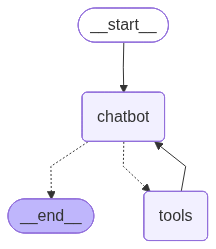

In [96]:
from typing import Annotated
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode,tools_condition
from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list,add_messages]

graph_builder=StateGraph(State)

@tool
def human_assistance(query:str):
    """
    Triggers an interruption in the agent's workflow to request external
    human help or clarification based on the given query.
    """ # <-- FIX: This docstring is required by @tool
    human_response=interrupt({'query':query})
    return human_response['data']

tool=TavilySearch(max_results=2)
tools=[tool,human_assistance]
llm_with_tools=llm.bind_tools(tools)

def chatbot(state:State):
    message=llm_with_tools.invoke(state['messages'])
    return {'messages':[message]}

graph_builder.add_node('chatbot',chatbot)
tool_node=ToolNode(tools=tools)
graph_builder.add_node('tools',tool_node)
graph_builder.add_conditional_edges(
    # Start node
    'chatbot',
    # Condition function (checks if a tool call was made)
    tools_condition,
    # Mapping of results: If true (tool call), go to 'tools'. If false (no tool call), go to END.
    {'tools': 'tools', END: END}
) 

# Edge from ToolNode back to Chatbot for tool results
graph_builder.add_edge('tools','chatbot')

# Starting Edge
graph_builder.add_edge(START,'chatbot')

# Compile the graph
graph=graph_builder.compile(checkpointer=memory) 
display(Image(graph.get_graph().draw_mermaid_png()))

In [97]:
user_input='I need some expert guidance for building an AI agent. Could you request assistnace for me?'
config={'configurable':{'thread_id':'6'}}

events=graph.stream({'messages':user_input},config,stream_mode='values')

events

<generator object Pregel.stream at 0x5608e8c0a860>

In [98]:
for event in events:
    print(event)
    if 'message' in event:
        event['messages'][-1].pretty_print()

{'messages': [HumanMessage(content='I need some expert guidance for building an AI agent. Could you request assistnace for me?', additional_kwargs={}, response_metadata={}, id='b1ce6a6d-bf33-4d63-9283-4785ae2a5625'), HumanMessage(content='I need some expert guidance for building an AI agent. Could you request assistnace for me?', additional_kwargs={}, response_metadata={}, id='3ef89e10-149a-4173-be0b-43637ea89579'), HumanMessage(content='I need some expert guidance for building an AI agent. Could you request assistnace for me?', additional_kwargs={}, response_metadata={}, id='786dc71a-dba8-4bc0-b90e-abd021da0ac4'), HumanMessage(content='I need some expert guidance for building an AI agent. Could you request assistnace for me?', additional_kwargs={}, response_metadata={}, id='3991a362-7edb-4203-ac8b-d217cb756a58'), HumanMessage(content='I need some expert guidance for building an AI agent. Could you request assistnace for me?', additional_kwargs={}, response_metadata={}, id='896ef07a-bb

In [100]:
user_input='I need some expert guidance and assistance for building an AI agent. Could you request assistnace for me?'
config={'configurable':{'thread_id':'6'}}

events=graph.stream({'messages':user_input},config,stream_mode='values')

for event in events:
    print(event)
    if 'message' in event:
        event['messages'][-1].pretty_print()

{'messages': [HumanMessage(content='I need some expert guidance for building an AI agent. Could you request assistnace for me?', additional_kwargs={}, response_metadata={}, id='b1ce6a6d-bf33-4d63-9283-4785ae2a5625'), HumanMessage(content='I need some expert guidance for building an AI agent. Could you request assistnace for me?', additional_kwargs={}, response_metadata={}, id='3ef89e10-149a-4173-be0b-43637ea89579'), HumanMessage(content='I need some expert guidance for building an AI agent. Could you request assistnace for me?', additional_kwargs={}, response_metadata={}, id='786dc71a-dba8-4bc0-b90e-abd021da0ac4'), HumanMessage(content='I need some expert guidance for building an AI agent. Could you request assistnace for me?', additional_kwargs={}, response_metadata={}, id='3991a362-7edb-4203-ac8b-d217cb756a58'), HumanMessage(content='I need some expert guidance for building an AI agent. Could you request assistnace for me?', additional_kwargs={}, response_metadata={}, id='896ef07a-bb

In [101]:
human_response={
    "We the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    "It's much more reliable and extensible than simple autonomous agents." 
}

human_comand=Command(resume={'data':human_response})

events=graph.stream(human_comand,config,stream_mode='values')

for event in events:
    print(event)
    if 'message' in event:
        event['messages'][-1].pretty_print()

{'messages': [HumanMessage(content='I need some expert guidance for building an AI agent. Could you request assistnace for me?', additional_kwargs={}, response_metadata={}, id='b1ce6a6d-bf33-4d63-9283-4785ae2a5625'), HumanMessage(content='I need some expert guidance for building an AI agent. Could you request assistnace for me?', additional_kwargs={}, response_metadata={}, id='3ef89e10-149a-4173-be0b-43637ea89579'), HumanMessage(content='I need some expert guidance for building an AI agent. Could you request assistnace for me?', additional_kwargs={}, response_metadata={}, id='786dc71a-dba8-4bc0-b90e-abd021da0ac4'), HumanMessage(content='I need some expert guidance for building an AI agent. Could you request assistnace for me?', additional_kwargs={}, response_metadata={}, id='3991a362-7edb-4203-ac8b-d217cb756a58'), HumanMessage(content='I need some expert guidance for building an AI agent. Could you request assistnace for me?', additional_kwargs={}, response_metadata={}, id='896ef07a-bb

## MCP Server and MCP Client from scratch

In [ ]:
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.prebuilt import create_react_agent
from langchain_groq import ChatGroq
#from dotenv import load_dotenv
#load_dotenv()
import asyncio
import os

async def main():
    client=MultiServerMCPClient(
        {
            'math':{
                'command':'python',
                'args':['mathserver.py'],
                'transport':'stdio'
            }, 
            'weather':{
                'url':'http://localhost:8000/mcp',
                'transport':'streamable_http'
            }
        }
    )

    tools=await client.get_tools()
    model=ChatGroq(model='llama3-8b-8192-groq')
    agent=create_react_agent(
        model,tools
    )

    math_response=await agent.ainvoke(
        {'messages':[{'role':'user','content':'What is (3+5) x 12?'}]}
    )

    print("Math response:",math_response['messages'][-1].content)

    await client.aclose() 

await main()